In [165]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential, save_model
from keras.layers import LSTM, Dropout, Dense

import matplotlib.pyplot as plt

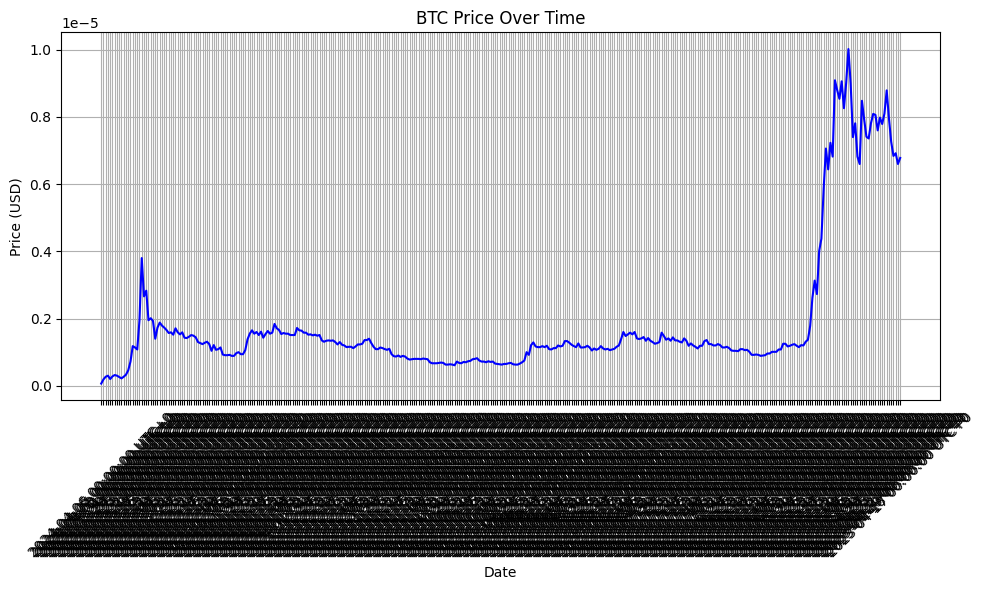

In [166]:
df = pd.read_csv('p_data.csv').dropna(axis=0)
f_df = df[['Date','Price']]

# Assuming selected_df contains the 'Date' and 'Price' columns
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Price'][::-1], color='blue', linestyle='-')
plt.title('BTC Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [167]:
f_df = f_df['Price']

sc = MinMaxScaler(feature_range=(0,1))

f_df = sc.fit_transform(np.array(f_df).reshape(-1,1))
print(f_df.shape)

(356, 1)


In [168]:
training_size=int(len(f_df)*0.60)
test_size=len(f_df)-training_size
train_data,test_data=f_df[0:training_size,:],f_df[training_size:len(f_df),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (213, 1)
test_data:  (143, 1)


In [169]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [170]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (197, 15)
y_train:  (197,)
X_test:  (127, 15)
y_test (127,)


In [171]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (197, 15, 1)
X_test:  (127, 15, 1)


In [172]:
model = Sequential([
    LSTM(10, input_shape=(None, 1), activation='relu'),
    Dense(1)
])

model.compile(loss="mean_squared_error",optimizer="adam")

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [173]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0712 - val_loss: 0.0125
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554 - val_loss: 0.0081
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0433 - val_loss: 0.0048
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0365 - val_loss: 0.0028
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 - val_loss: 0.0021
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - val_loss: 0.0027
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 - val_loss: 0.0043
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 - val_loss: 0.0059
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 - val_loss: 0.0054
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0041
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0029
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0023


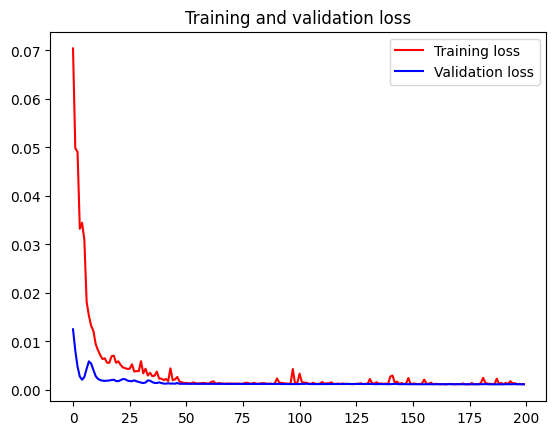

<Figure size 640x480 with 0 Axes>

In [174]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [175]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


((197, 1), (127, 1))

In [176]:
train_predict = sc.inverse_transform(train_predict)
test_predict = sc.inverse_transform(test_predict)
original_ytrain = sc.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = sc.inverse_transform(y_test.reshape(-1,1)) 

In [177]:
print(train_predict)

print('Now test data')
print(test_predict[:,0])



[[7.8870253e-06]
 [7.6252677e-06]
 [7.5473704e-06]
 [7.7179402e-06]
 [7.1660997e-06]
 [6.7949518e-06]
 [6.9330035e-06]
 [7.0504739e-06]
 [7.6377237e-06]
 [8.4488483e-06]
 [8.8404622e-06]
 [8.9219011e-06]
 [9.2683686e-06]
 [9.2400351e-06]
 [9.0551257e-06]
 [8.9617779e-06]
 [8.0319551e-06]
 [7.4127847e-06]
 [6.6665357e-06]
 [6.0509306e-06]
 [5.1966726e-06]
 [4.1714306e-06]
 [3.2616376e-06]
 [2.5348168e-06]
 [2.4344993e-06]
 [2.2006702e-06]
 [1.8359044e-06]
 [1.5806470e-06]
 [1.4305097e-06]
 [1.3509684e-06]
 [1.3454084e-06]
 [1.2667884e-06]
 [1.2438185e-06]
 [1.2346314e-06]
 [1.2304057e-06]
 [1.2150746e-06]
 [1.1989208e-06]
 [1.2036634e-06]
 [1.2076005e-06]
 [1.1841279e-06]
 [1.1650699e-06]
 [1.1355045e-06]
 [1.1100586e-06]
 [1.0890366e-06]
 [1.0622591e-06]
 [1.0401420e-06]
 [1.0131437e-06]
 [9.8971168e-07]
 [9.6919916e-07]
 [9.5787584e-07]
 [9.5115695e-07]
 [9.4544350e-07]
 [9.4180319e-07]
 [9.5558187e-07]
 [9.7841109e-07]
 [9.9645672e-07]
 [1.0172936e-06]
 [1.0350412e-06]
 [1.0390768e-0

In [178]:

x_input=f_df[::-1][len(f_df)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [179]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [180]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = sc.inverse_transform(f_df[len(f_df)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = sc.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})


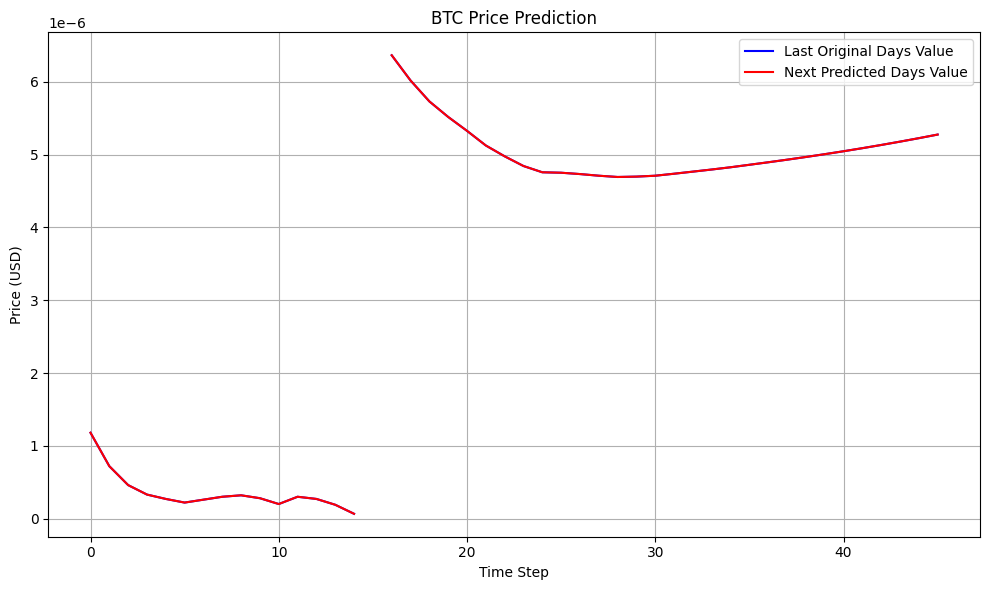

In [181]:


plt.figure(figsize=(10, 6))
plt.plot(new_pred_plot.index, new_pred_plot['last_original_days_value'], color='blue', label='Last Original Days Value')
plt.plot(new_pred_plot.index, new_pred_plot['next_predicted_days_value'], color='red', label='Next Predicted Days Value')
plt.title('BTC Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [182]:
from itertools import cycle

lstmdf=f_df[::-1].tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=sc.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

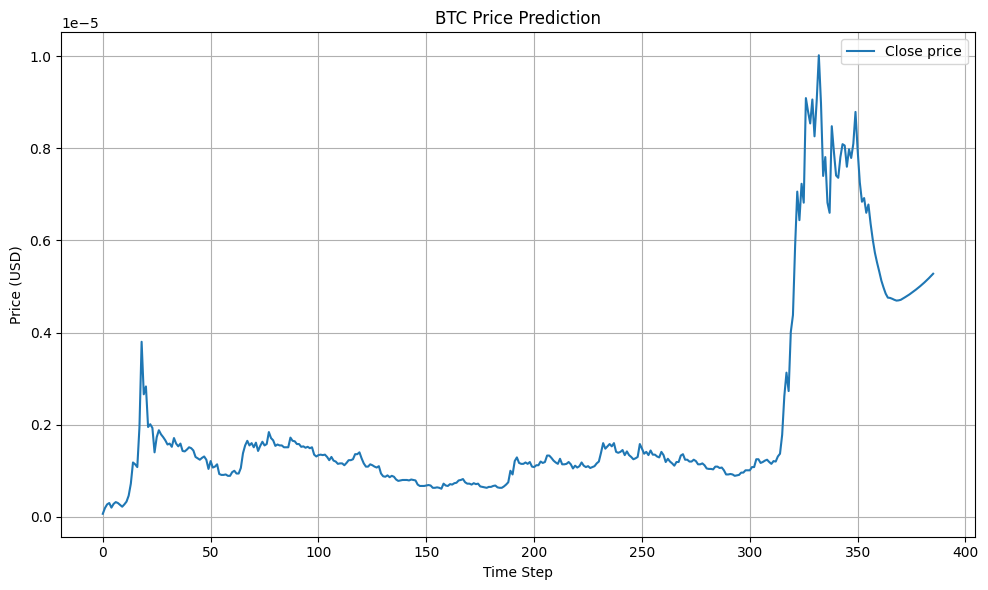

In [183]:

# Plot the data
plt.figure(figsize=(10, 6))
for name, data in zip(names, [lstmdf]):
    plt.plot(data, label=name)

plt.title('BTC Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


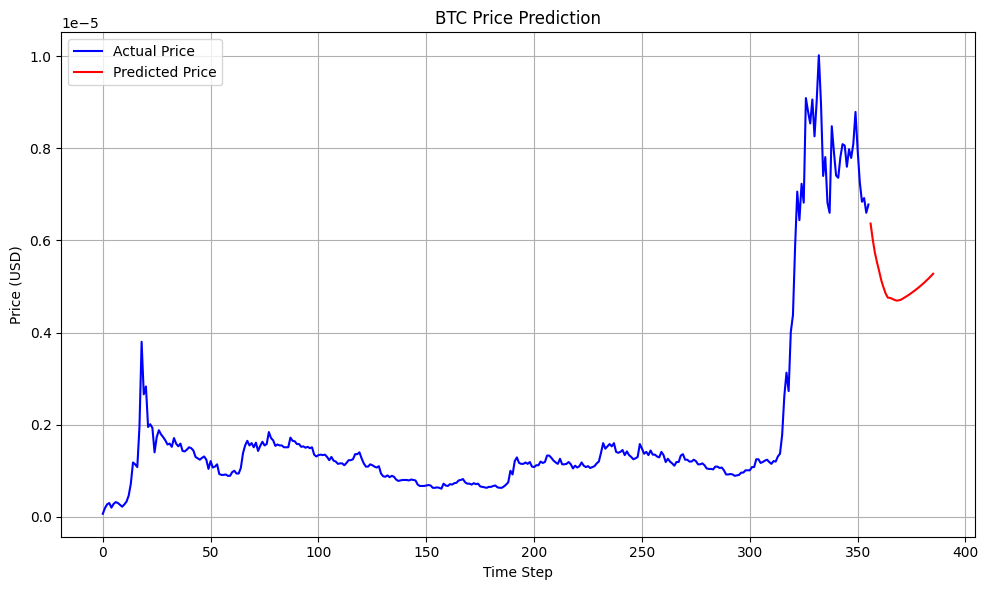

In [184]:
# Plot the data
plt.figure(figsize=(10, 6))

# Plot actual data
plt.plot(lstmdf[:len(f_df)], color='blue', label='Actual Price')

# Plot predicted data
plt.plot(range(len(f_df), len(lstmdf)), lstmdf[len(f_df):], color='red', label='Predicted Price')

plt.title('BTC Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



here 1 timestep is equal to a 15 day interval of data, hence, 1 timestep = 15 days

In [185]:
save_model(model, 'pepe_model.keras')